# The Bayesian LASSO Regression

## Rahmat Ashari

**Fall 2021 PGE 383 Subsurface Machine Learning at The University of Texas at Austin**

**Hildebrand Department of Petroleum & Geosystems Engineering - Cockrell School of Engineering**

ra37697 - rahx@utexas.edu

_____________________

**Workflow supervision and review by:**

**Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin**

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

**Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin**

[LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)

## Executive Summary

The LASSO regression can be interpreted from the perspective of Bayesian statistics, where the mode of the posterior distribution can be seen as a point estimate for the parameters. A simple single-predictor model fitting was exercised and compared with the frequentist LASSO regression at different $\lambda$ values. Adopting the Bayesian approach to LASSO regression delivers the capability of assessing the uncertainty in the model parameters, as well as regularization.

## The Theory

From a Bayesian point of view, a linear regression model can be expressed as

$$
Y = \mu1 + \sum_{i = 1}^N X \beta_i + \epsilon
$$

where the residuals $\epsilon \sim N(0, \sigma^2)$, a prior $p(\beta) = \prod_{i = 1}^N g(\beta_i)$, and a likelihood $p(y) \sim N(\mu1 + X\beta, \sigma^2I)$. The LASSO regularization is expressed as 

$$
\lambda \sum_{i=1}^N|\beta_i|
$$

where $|\beta_i|$ is the L1 norm. If the prior $g(\beta)$ is a Laplace density with mean 0 and a scale parameter defined as a function of $\lambda$, then the posterior mode for $\beta$ is the LASSO solution (James et al, 2017). The Laplace prior for the $\beta$ can be parametrized as 

$$
p(\beta | \sigma^2) = \prod\frac{\lambda}{2\sqrt{\sigma^2}} \exp(-\lambda\beta_i/\sqrt{\sigma^2})
$$

The prior is conditioned by $\sigma^2$ to guarantee unimodality in the posterior distribution (Park and Castella, 2008). In a full Bayesian model, a hyperprior can be set for $\lambda$. However, in this workflow, $\lambda$ will be predetermined. 

## Import Dependencies and Workflow Set-ups

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import pymc3 as pm
import warnings
seed = 2021

# the lines below are purely for aesthetics
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 12
plt.rcParams['figure.dpi']= 100

# Hide ONLY deprecation warning
warnings.filterwarnings("ignore", category=DeprecationWarning) 

**note**

The package `pymc3` is not installed by default with Anaconda installation. For Windows, installation is trivial by using conda. For MacOS (particularly if you are using arm chip), refer to https://github.com/pymc-devs/pymc/wiki/Installation-Guide-(MacOS)

## Univariate Bayesian Lasso Regression

In this section, the goal is to fit a linear regression with LASSO regularization to predict production using only permeability. A synthetic dataset `unconv_MV_v4.csv` will be used. This dataset is available at Dr. Pyrcz's GitHub data repository. 

### Read Data and Standardization

As an intial step, it is always a good practice to examine the imported data. Unlike in multiple statistical learning approaches, features standardization for a single-predictor linear regression is not highly influential to inferring model parameters. Thus, in this exercise, the predictor and target features are left in their original scale. 

In [2]:
data = pd.read_csv("unconv_MV_v4.csv")
scaler = StandardScaler()
dataSt = pd.DataFrame(scaler.fit_transform(data))
dataSt.columns = data.columns
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,1695.360819
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3007.096063
2,3,14.02,2.59,4.01,72.80,0.89,2.72,2531.938259
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5288.514854
4,5,17.52,4.57,3.18,10.94,1.51,1.90,2859.469624


The next step is to examine the summary statistics of the standardized data. This step can reveal if there is any extreme outliers present in the dataset. 

In [3]:
dataSt.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Well,200.0,-6.661338e-18,1.002509,-1.723412,-0.861706,0.000000,0.861706,1.723412
Por,200.0,2.620126e-16,1.002509,-2.848142,-0.701361,0.026605,0.813617,2.887855
Perm,200.0,-5.662137e-17,1.002509,-1.853701,-0.699753,-0.171282,0.554098,3.208033
AI,200.0,3.985701e-16,1.002509,-2.986650,-0.745137,-0.024493,0.665203,2.937664
Brittle,200.0,1.824929e-16,1.002509,-2.640962,-0.738391,0.095646,0.716652,2.566186
TOC,200.0,3.552714e-16,1.002509,-2.457313,-0.776361,0.082330,0.748466,2.476256
VR,200.0,9.126033e-16,1.002509,-3.446814,-0.647507,-0.014330,0.593853,3.018254
Prod,200.0,7.549517e-17,1.002509,-1.952114,-0.760415,-0.167875,0.573278,3.050219


Only `Perm` and `Prod` columns are needed in this exercise, and both look proper. A quick visualization never hurt!

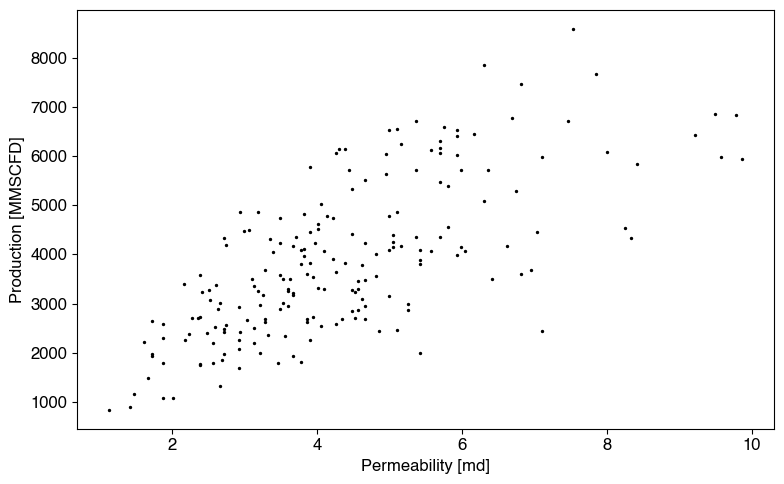

In [4]:
x = data["Perm"]
y = data["Prod"]

plt.figure(figsize = (8,5))
plt.scatter(x, y, color = "black", s = 2)
plt.xlabel("Permeability [md]")
plt.ylabel("Production [MMSCFD]")
plt.tight_layout()
plt.show()

### Building the Bayesian LASSO Model

In this section, the linear regression model with LASSO regularization will be constructed. The following likelihood and priors are used

$$
\begin{aligned}
p(y | - ) &\sim N(\mu1 + X\beta, \sigma^2) \\
p(\beta | -) &\sim Laplace(0, b) \\
p(\sigma^2) &\sim InverseGamma(1, 10) \\
p(\mu) &\sim Flat
\end{aligned}
$$

where $b = \frac{\sqrt{\sigma^2}}{\lambda}$

For this exercise, $\lambda = 10$. The choice of the parameters in the prior for $\sigma^2$ is to make the prior non-informative, so that the data can play a larger role in updating the parameters.

In [5]:
lambd = 10

with pm.Model() as bayesLassoUni:
    # declare priors
    intercept = pm.Flat("intercept")
    sigmaSq = pm.InverseGamma("sigmaSq", alpha = 1, beta = 10)
    beta = pm.Laplace("beta", mu = 0, b = sigmaSq**0.5/lambd)
    
    # construct model
    modelMean = intercept + (beta * x)
    
    # define likelihood
    likelihood = pm.Normal('likelihood', mu = modelMean, sd = sigmaSq**0.5, observed = y)
    
    # set up posterior sampling 
    step = pm.NUTS(target_accept = 0.95)
    
    # get trace and maximum a posteriori (MAP)
    posteriorMode = pm.find_MAP()
    trace = pm.sample(draws = 1000, tune = 4000, step = step, start = posteriorMode,
                      random_seed = seed, return_inferencedata = True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigmaSq, intercept]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 22 seconds.


The mode of the posterior (a.k.a the Bayesian LASSO point estimates for the parameters)

In [6]:
print(posteriorMode)

{'intercept': array(1203.79181425), 'sigmaSq_log__': array(14.00715195), 'beta': array(614.35460452), 'sigmaSq': array(1211236.07654289)}


The summary statistics for the posterior and the diagnostic plots

In [7]:
with bayesLassoUni:
    print(pm.stats.summary(trace))

                  mean          sd       hdi_3%      hdi_97%  mcse_mean  \
intercept     1210.081     213.452      817.845     1630.492      5.504   
beta           613.104      46.295      521.396      696.475      1.207   
sigmaSq    1248006.007  123697.280  1023157.551  1479085.405   3221.440   

            mcse_sd  ess_bulk  ess_tail  r_hat  
intercept     3.893    1507.0    1467.0    1.0  
beta          0.857    1470.0    1902.0    1.0  
sigmaSq    2293.295    1553.0    1708.0    1.0  


Examine the traceplots to see how the chains look like

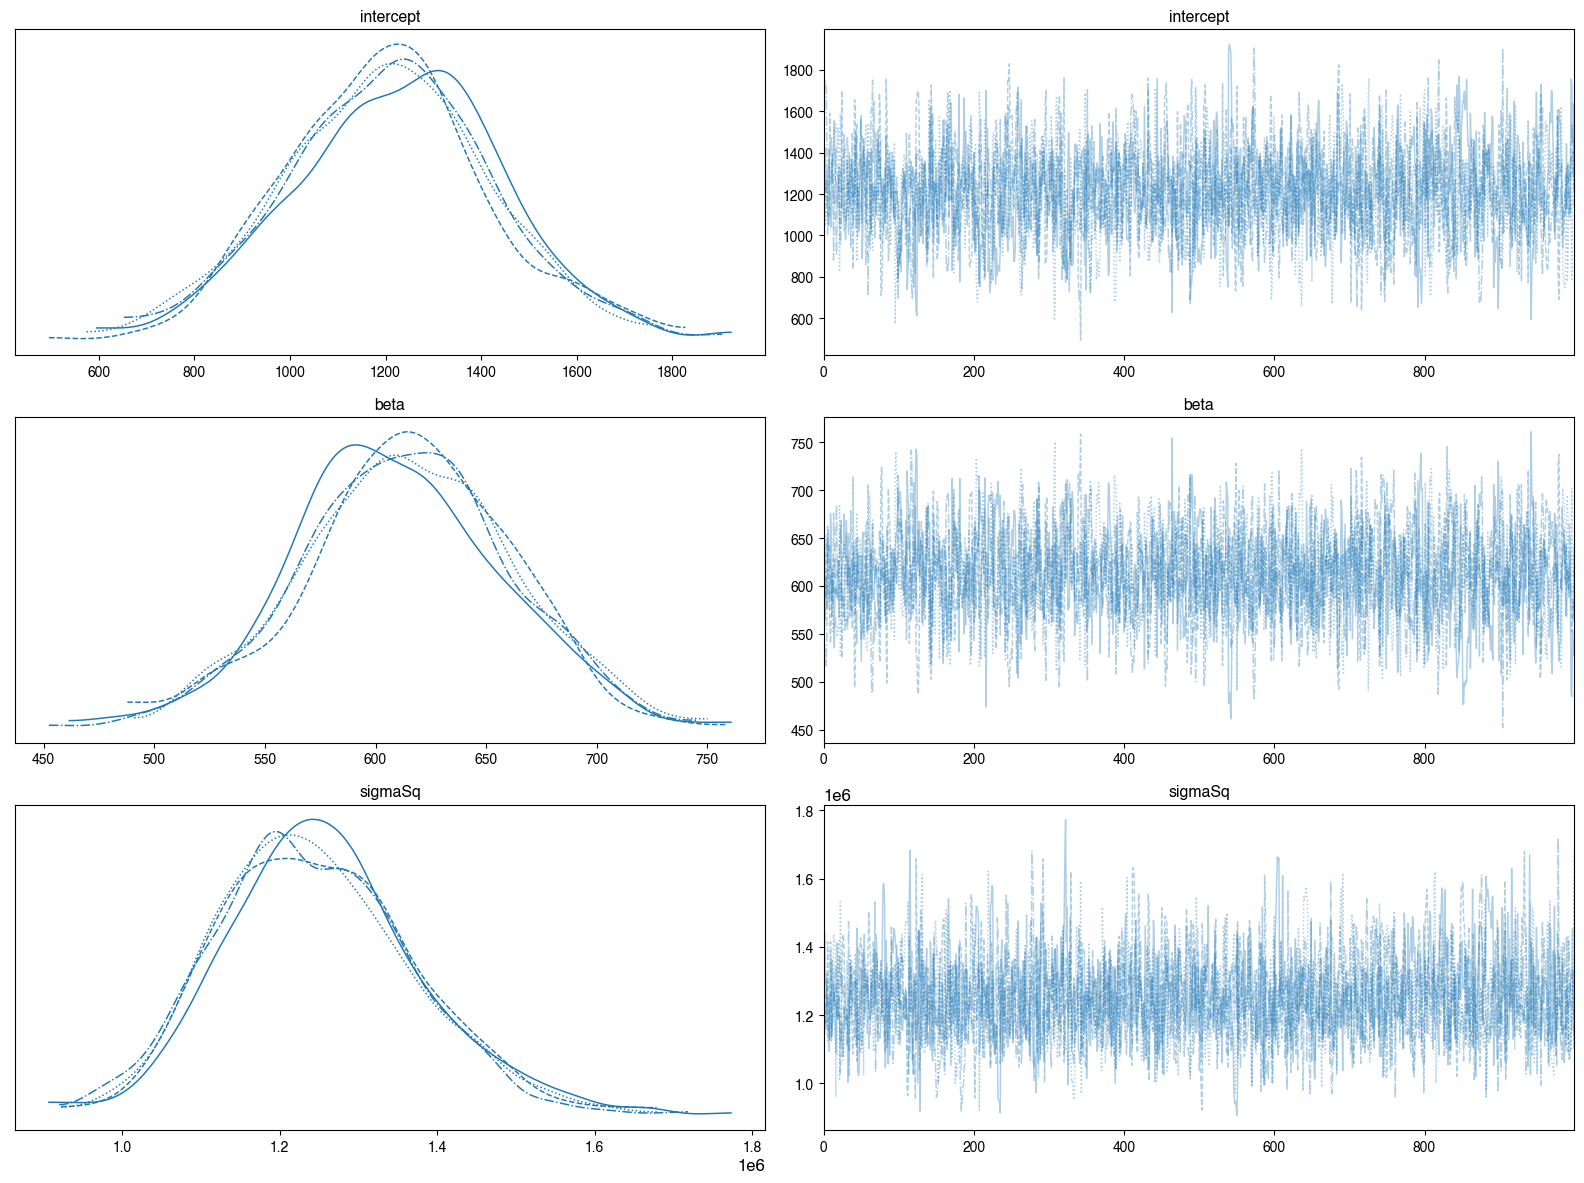

In [8]:
with bayesLassoUni:
    pm.plot_trace(trace, figsize = (16,12))

plt.tight_layout()
plt.show()

Chains look stationary as expected!

### Building the Frequentist Lasso Fit

This is simply just to see how frequentist LASSO regularizarion performs for the same predictor and target features for comparison purposes.

In [9]:
# reshape for compatibility
X = x.values.reshape(-1,1)

# Lasso model
modelLasso = Lasso(alpha = lambd)
modelLasso.fit(X,y)
yhatLasso = modelLasso.predict(X)

### Comparing Bayesian with Frequenstist Lasso

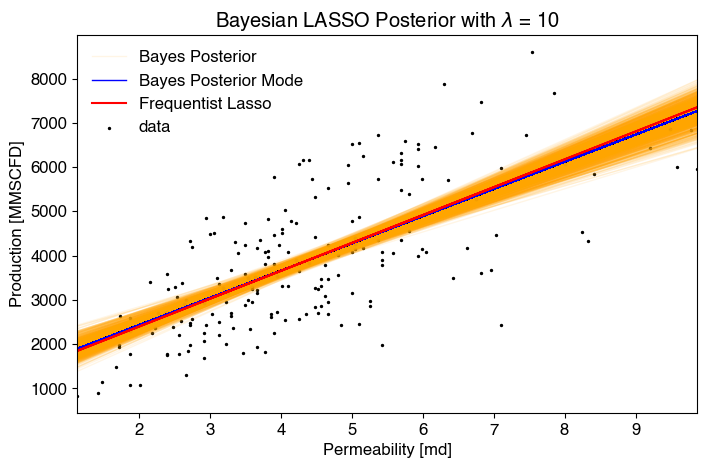

In [10]:
plt.figure(figsize = (8,5))
plt.scatter(x, y, color = "black", label = "data", s = 2)
pm.plot_posterior_predictive_glm(trace, samples = 1000, eval = np.linspace(min(x), max(x), 100), linewidth = 1, color = 'orange', alpha = 0.1, 
                                  label = 'Bayes Posterior',lm = lambda x, sample: sample['intercept'] + sample['beta'] * x)
pm.plot_posterior_predictive_glm(trace, samples = 1000, eval = np.linspace(min(x), max(x), 100), 
                                 linewidth = 1, color = 'blue',
                                 label = 'Bayes Posterior Mode',
                                 lm = lambda x, sample: posteriorMode['intercept'] + posteriorMode['beta'] * x)
plt.plot(x, yhatLasso, color = "red", label = "Frequentist Lasso")
plt.xlabel("Permeability [md]")
plt.ylabel("Production [MMSCFD]")
plotTitle = r"Bayesian LASSO Posterior with $\lambda$ = " + str(lambd)
plt.title(plotTitle)
plt.xlim([min(x), max(x)])
plt.legend(frameon = False)
plt.show()

Observe that the frequentist and Bayesian (point) estimates for the slope are quite close. For the case of Bayesian LASSO regression, we can also assess the whole distribution of the slopes, which can be quite useful for uncertainty analysis. 

### The Effects of $\lambda$

**Notice**

This might take a while: run at your own risk. It took my local machine about 1-2 mins to run the chunk below. 

In the chunk below, we are building similar model but at different $\lambda$ values

In [11]:
lambdaList = [0.01, 10, 100, 10000]

traceList = []
modeList = []

for l in lambdaList:
    print(l)
    with pm.Model() as bayesLassoUni:
        # declare priors
        intercept = pm.Flat("intercept")
        sigmaSq = pm.InverseGamma("sigmaSq", alpha = 1, beta = 10)
        beta = pm.Laplace("beta", mu = 0, b = sigmaSq**0.5/l)

        # construct model
        modelMean = intercept + (beta * x)

        # define likelihood
        likelihood = pm.Normal('likelihood', mu = modelMean, sd = sigmaSq**0.5, observed = y)

        # set up posterior sampling 
        step = pm.NUTS(target_accept = 0.95)

        # get trace and maximum a posteriori (MAP)
        posteriorMode = pm.find_MAP()
        trace = pm.sample(draws = 500, tune = 4000, step = step, start = posteriorMode,
                          random_seed = seed, return_inferencedata = True)
        
    traceList.append(trace)
    modeList.append(posteriorMode)
    

0.01


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigmaSq, intercept]


Sampling 4 chains for 4_000 tune and 500 draw iterations (16_000 + 2_000 draws total) took 21 seconds.


10


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigmaSq, intercept]


Sampling 4 chains for 4_000 tune and 500 draw iterations (16_000 + 2_000 draws total) took 21 seconds.


100


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigmaSq, intercept]


Sampling 4 chains for 4_000 tune and 500 draw iterations (16_000 + 2_000 draws total) took 21 seconds.


10000


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigmaSq, intercept]


Sampling 4 chains for 4_000 tune and 500 draw iterations (16_000 + 2_000 draws total) took 21 seconds.


Next, the frequentist LASSO regression will be built for different $\lambda$ values, to serve as comparisons

In [12]:
# Lasso model
yhatLassoList = []
for l in lambdaList:
    modelLasso = Lasso(alpha = l)
    modelLasso.fit(X,y)
    yhatLasso = modelLasso.predict(X)
    yhatLassoList.append(yhatLasso)

Visualization to compare how the parameters change at different $\lambda$ values

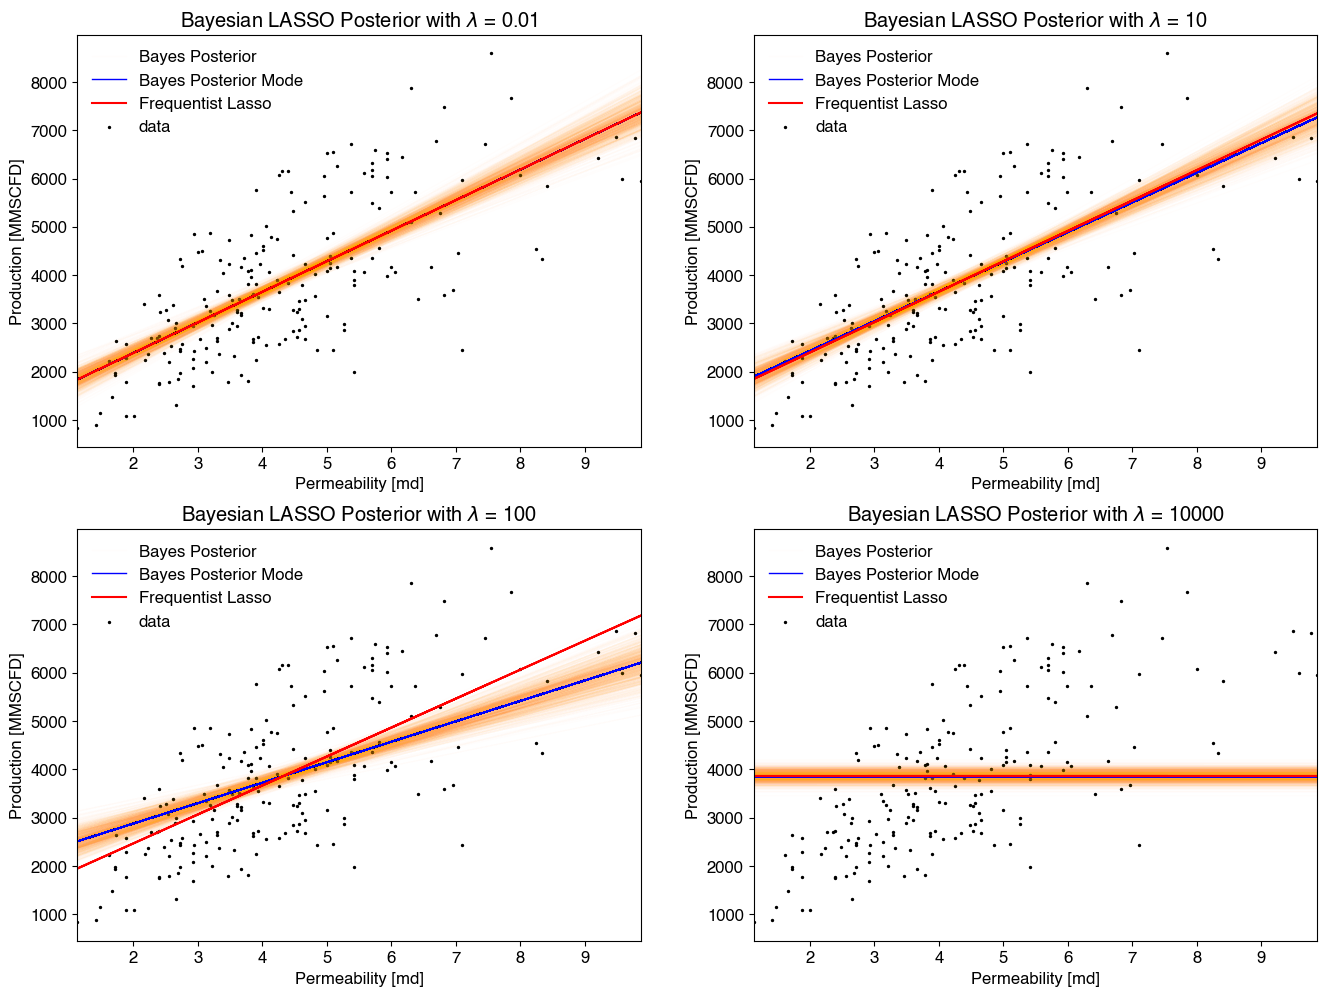

In [13]:
plt.figure(figsize = (16,12))
for idx,l in enumerate(lambdaList):
    plt.subplot(2,2,idx + 1)
    plt.scatter(x, y, color = "black", label = "data", s = 2)
    pm.plot_posterior_predictive_glm(traceList[idx], samples = 1000, eval = np.linspace(min(x), max(x), 100), linewidth = 1, color = 'orange', alpha = 0.01, 
                                     label = 'Bayes Posterior',lm = lambda x, sample: sample['intercept'] + sample['beta'] * x)
    pm.plot_posterior_predictive_glm(traceList[idx], samples = 1000, eval = np.linspace(min(x), max(x), 100), 
                                     linewidth = 1, color = 'blue',
                                     label = 'Bayes Posterior Mode',
                                     lm = lambda x, sample: modeList[idx]['intercept'] + modeList[idx]['beta'] * x)
    plt.plot(x, yhatLassoList[idx], color = "red", label = "Frequentist Lasso")
    plt.xlabel("Permeability [md]")
    plt.ylabel("Production [MMSCFD]")
    plotTitle = r"Bayesian LASSO Posterior with $\lambda$ = " + str(l)
    plt.title(plotTitle)
    plt.xlim([min(x), max(x)])
    plt.legend(frameon = False)
plt.show()

PUT DESC

In [14]:
betaList = [float(modeList[i]["beta"]) for i in range(len(modeList))]
betaList

[632.7932967613533,
 614.3546045197111,
 423.13298720269916,
 -1.0747865712190971e-08]

## References

Work in Progress ~